In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
from os import sys, path
sys.path.append(path.dirname(path.dirname(path.abspath('__file__'))))

In [3]:
from pack.utils import (transition_matrix_pxx, emission_probabilities_pyx, string_list_to_numpy)

In [4]:
from sklearn import metrics
from sklearn import preprocessing

In [5]:
from algorithms.hmm import ForwardBackwardAlgorithm

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# GET X AND Y STATES

#### READ THE DATA OF INTEREST

In [7]:
pred = pd.read_csv('../data/predict.csv', index_col='Unnamed: 0')
champs = pred.championship.dropna().drop_duplicates().values

In [8]:
ysdf = []
for champ in champs[:]:
# champ = champs[]
    temp = pred[pred.championship==champ]
    # print(temp.head(1))
    ht = temp.home_team.drop_duplicates().dropna().values
    at = temp.away_team.drop_duplicates().dropna().values
    allt = np.append(ht,at)
#     all_teams = np.unique(allt)
    try:
        elo = pd.read_csv('../data/elo_ratings/ratings/'+champ+'.csv', index_col='Unnamed: 0')
        try:
            for i in range(ht.shape[0]):
                try:
                    Hysmixed = elo[ht[i]].dropna()
                    Aysmixed = elo[at[i]].dropna()
                    ysdf.append([Hysmixed,Aysmixed])
                except Exception as e:
    #                 print('[ERROR1]',e)
                    pass
        except Exception as e:
    #         print(e)
            pass
    except Exception as e:
        print(e)

File b'../data/elo_ratings/ratings/N/C America - CFU Club Championship.csv' does not exist


### READ ALL DATA

In [9]:
df = pd.read_csv('/home/kasper/Dropbox/Scrapping/soccerway/csv/final_data_soccerway.csv', index_col='Unnamed: 0')

In [10]:
result_key = 'over_under_3.5'

### SAVE STATES X AND Y TO JSON FILE

In [11]:
jfile = {}
for i in range(len(ysdf)):
    home, away = ysdf[i][0], ysdf[i][1]
    for_home_team_xdf = df.loc[home.index][result_key]
    for_away_team_xdf = df.loc[away.index][result_key]
    jfile[home.name]={'xs':for_home_team_xdf.values,'ys':home.values}
    jfile[away.name]={'xs':for_away_team_xdf.values,'ys':away.values}

##### plot for fun

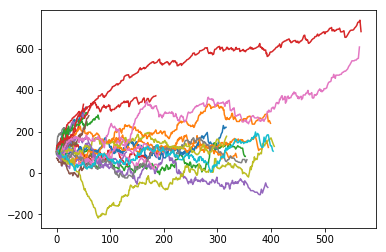

In [12]:
for i in range(len(ysdf)):
    plt.plot(jfile[list(jfile.keys())[i]]['ys'])

#### transform the ys

In [13]:
for key in jfile.keys():
    ys_trans = pd.DataFrame(jfile[key]['ys']).diff().replace(np.nan, 0).astype(int).values
    jfile[key]['ys_trans'] = ys_trans

# TRAIN THE MODEL

In [14]:
json_model = {}

In [15]:
output = []

In [22]:
for i in range(len(ysdf)):
    data = jfile[list(jfile.keys())[i]]
    team_name = list(jfile.keys())[i]
    train_period = -15

    xs = data['xs']
    ys = data['ys_trans']

    X_train =xs[:train_period]
    Y_train =ys[:train_period]

    X_test =xs[train_period:]
    Y_test =ys[train_period:]

    px = pd.DataFrame(X_train,columns=[result_key])[result_key].value_counts(normalize=True).sort_index().values
    pxx = transition_matrix_pxx(data=pd.DataFrame(X_train,columns=[result_key]),n_states=3,result=result_key)
    pyx = emission_probabilities_pyx(x_df=pd.DataFrame(X_train,columns=[result_key]),y_df=pd.DataFrame(Y_train,columns=[result_key]),hidden_states=3,x_label=result_key)


    try:
        unique_observed_data_elo_ratings = np.unique(Y_train)
        le = preprocessing.LabelEncoder()
        le.fit(unique_observed_data_elo_ratings)
        transformed_observed_data_elo_ratings = le.transform(Y_test.reshape(-1))
    except Exception as e:
#         print(e)
        continue
    try:
        fba = ForwardBackwardAlgorithm(px, pxx, pyx, transformed_observed_data_elo_ratings)
        forward = fba.forward()

        backward = fba.backward()
        gammas = fba.gammas()
    except Exception as e:
        pass

    try:
        ac = metrics.accuracy_score(X_test, np.argmax(gammas, axis=1))
        rec = metrics.recall_score(X_test, np.argmax(gammas, axis=1))
        pre = metrics.precision_score(X_test, np.argmax(gammas, axis=1))
        print(team_name, ac)
        output.append([team_name,ac,rec,pre])
    except Exception as e:
        print(e)
        pass

/home/kasper/PycharmProjects/PGMS/pack/utils.py:176: RuntimeWarning: invalid value encountered in true_divide
  transition_matrix[state, :] = transition_matrix[state, :]/transition_matrix[state, :].sum()
/home/kasper/PycharmProjects/PGMS/pack/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  pyx[i, :] = pyx[i, :] / s


Mixco 0.7333333333333333
Classification metrics can't handle a mix of continuous and binary targets
Brusque 0.6
Romford 0.7333333333333333
Hibernian 0.7333333333333333
Iztapa 0.8666666666666667
El Geish 1.0
Anapolina 0.9333333333333333
UCR 0.7333333333333333
AFC Hornchurch 0.7333333333333333
Doxa 0.7333333333333333
Malacateco 0.3333333333333333


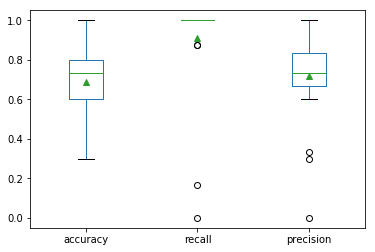

In [23]:
df3 = pd.DataFrame(output, columns = ['team','accuracy','recall','precision'])
df3[['accuracy','recall','precision']].plot(kind='box', showmeans=True)